## _SECCIÓN 1_: ANÁLISIS EXPLORATORIO DE DATOS (EDA) Y COMPARATIVA CON EL PAPER

🚀 INICIANDO EJECUCIÓN DEL SCRIPT DE EDA PROFESIONAL...
✅ 1. DATOS CARGADOS: 494 registros válidos (se eliminaron 6 inconsistentes).

🔬 2. ANÁLISIS ESTADÍSTICO Y DISTRIBUCIONES

--- 2.1 Estadísticas Descriptivas (Asimetría y Outliers) ---
                                 mean       50%        max           std   skewness  outliers_%
Impressions_Liked_Page   16946.230769    6283.5  1107833.0  60131.296754  14.642873        10.7
Shares                      27.543788      19.0      790.0     42.740599  12.159614         6.5
Comments                     7.572874       3.0      372.0     21.293224  11.711543        10.5
Total_Interactions         214.696356     125.0     6334.0    381.814783   9.691689         7.9
Likes                      179.746964     101.5     5172.0    324.535159   8.936766         8.1
Impressions              29915.708502    9091.0  1110282.0  77210.414658   8.307695        13.4
Consumers                  808.190283     555.5    11328.0    883.677077   5.050490       

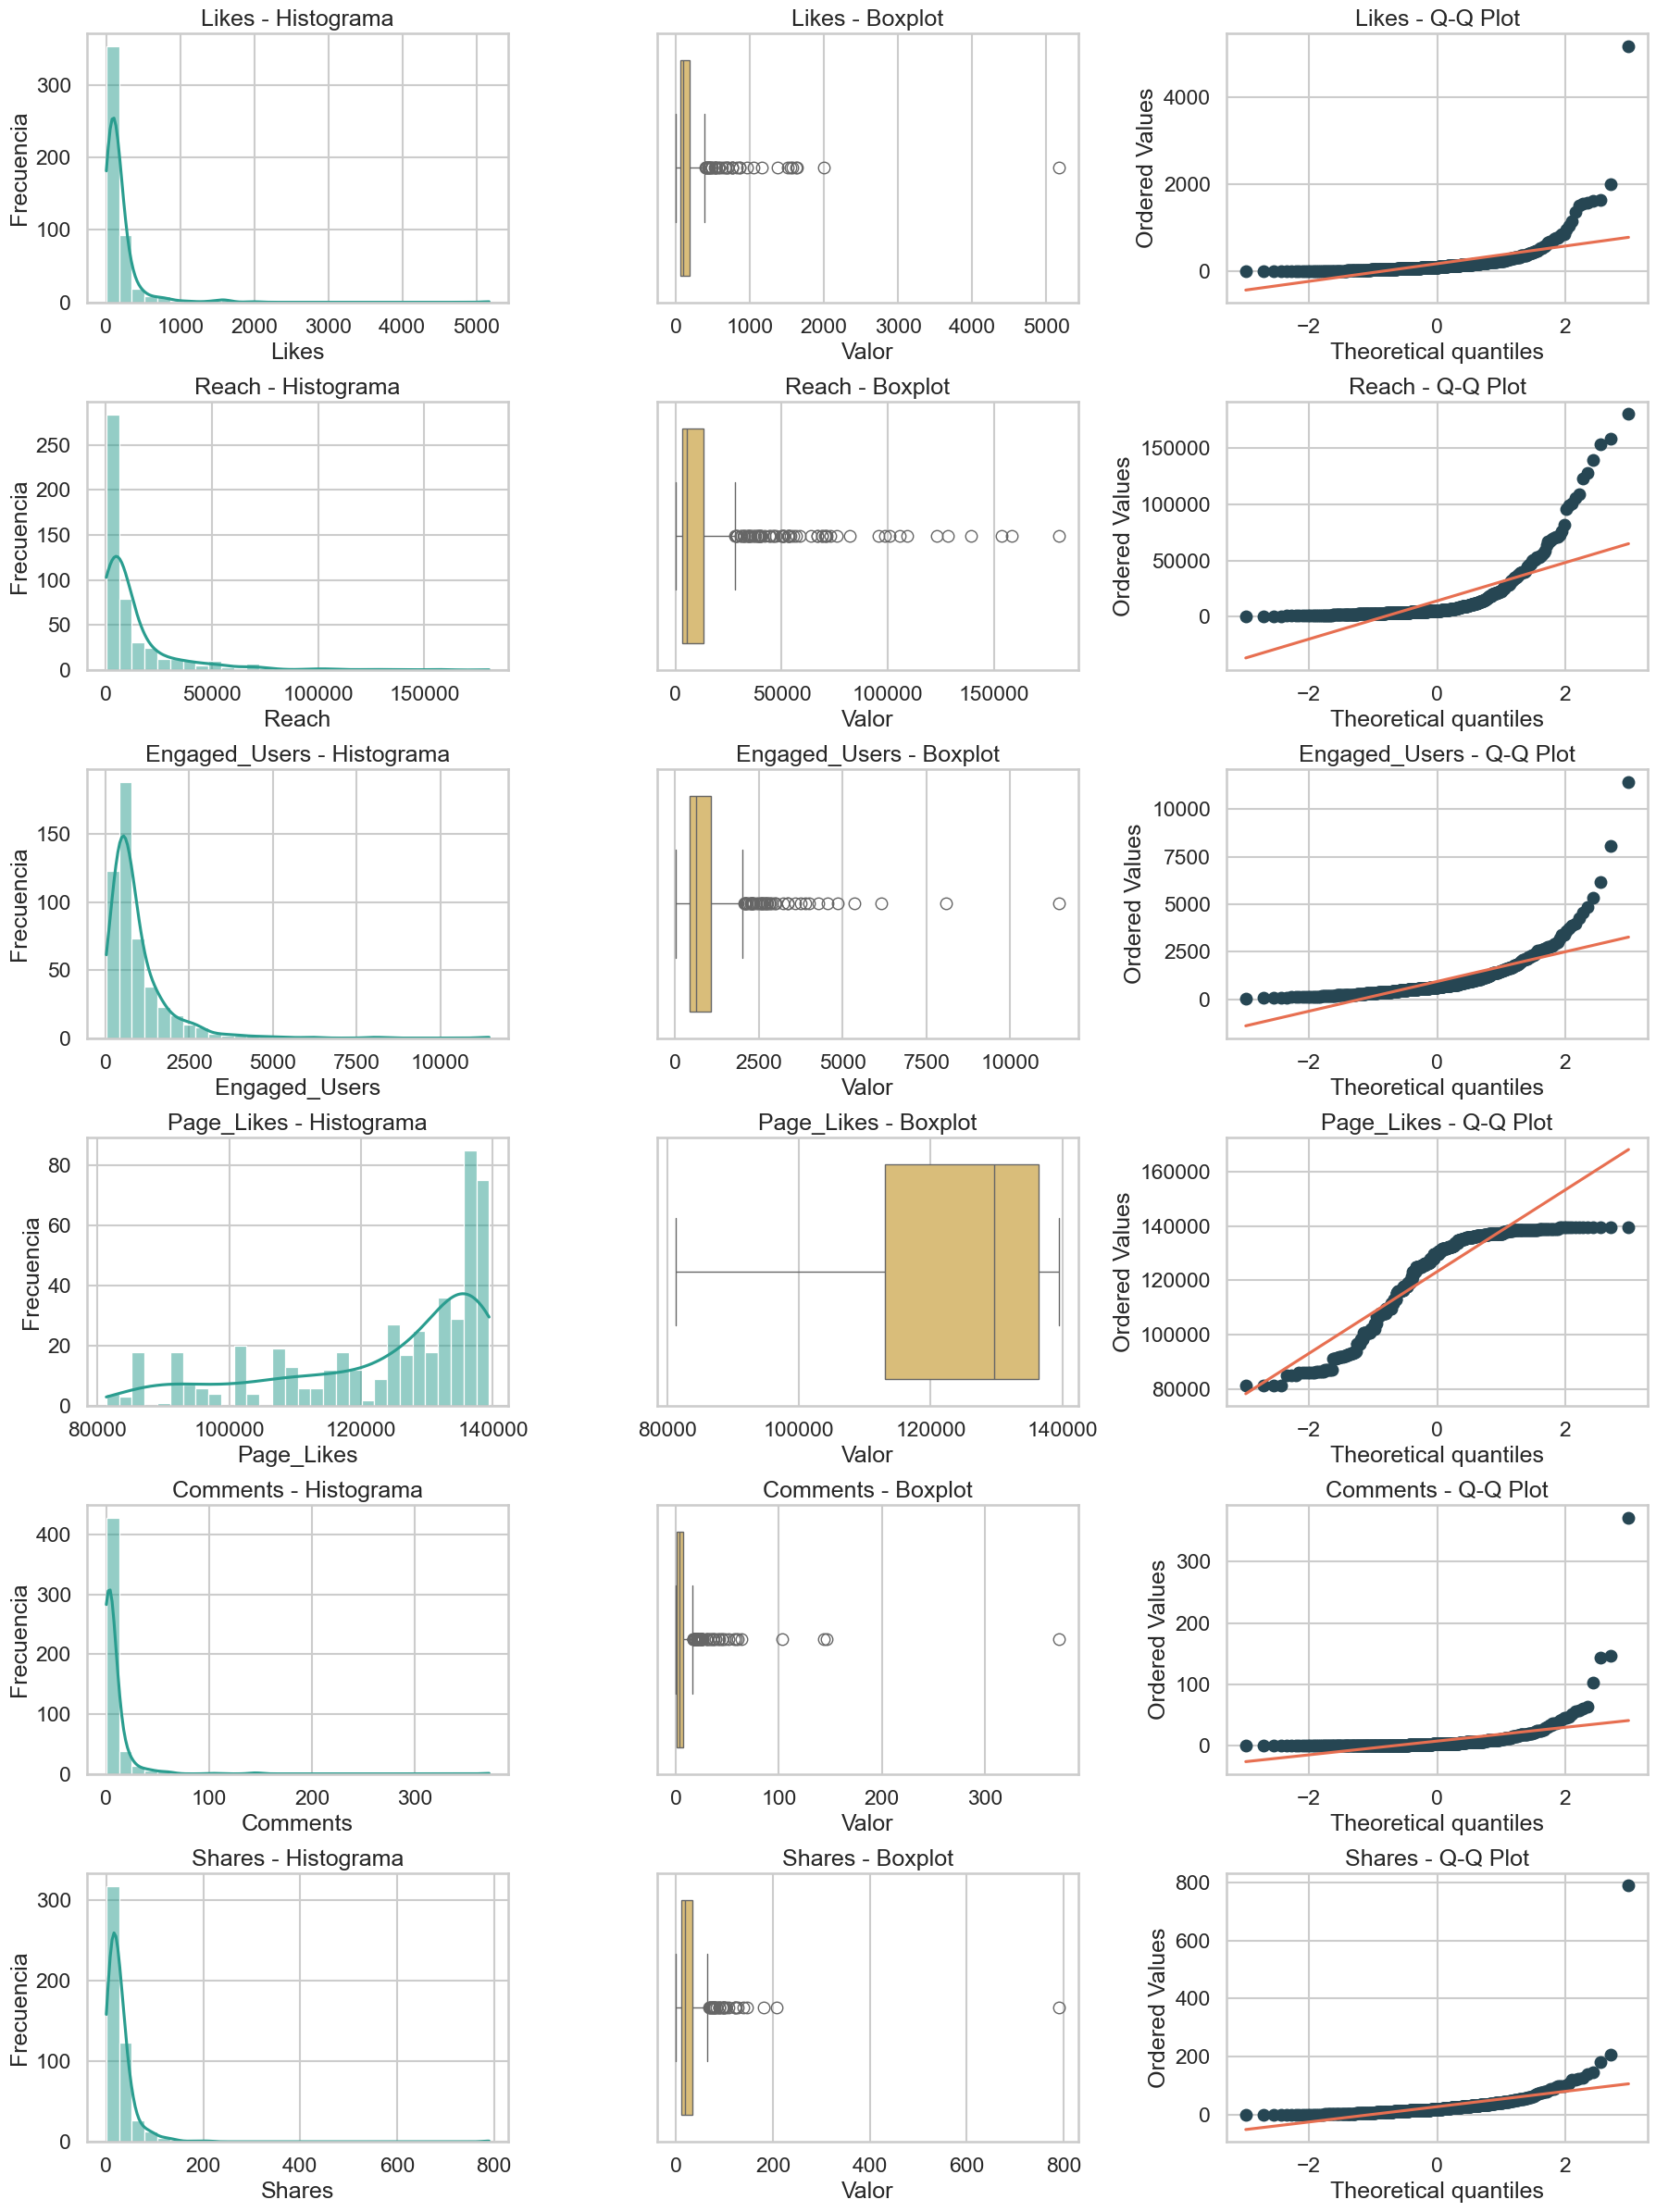


📅 3. EVOLUCIÓN TEMPORAL (COMUNIDAD VS INTERACCIÓN)


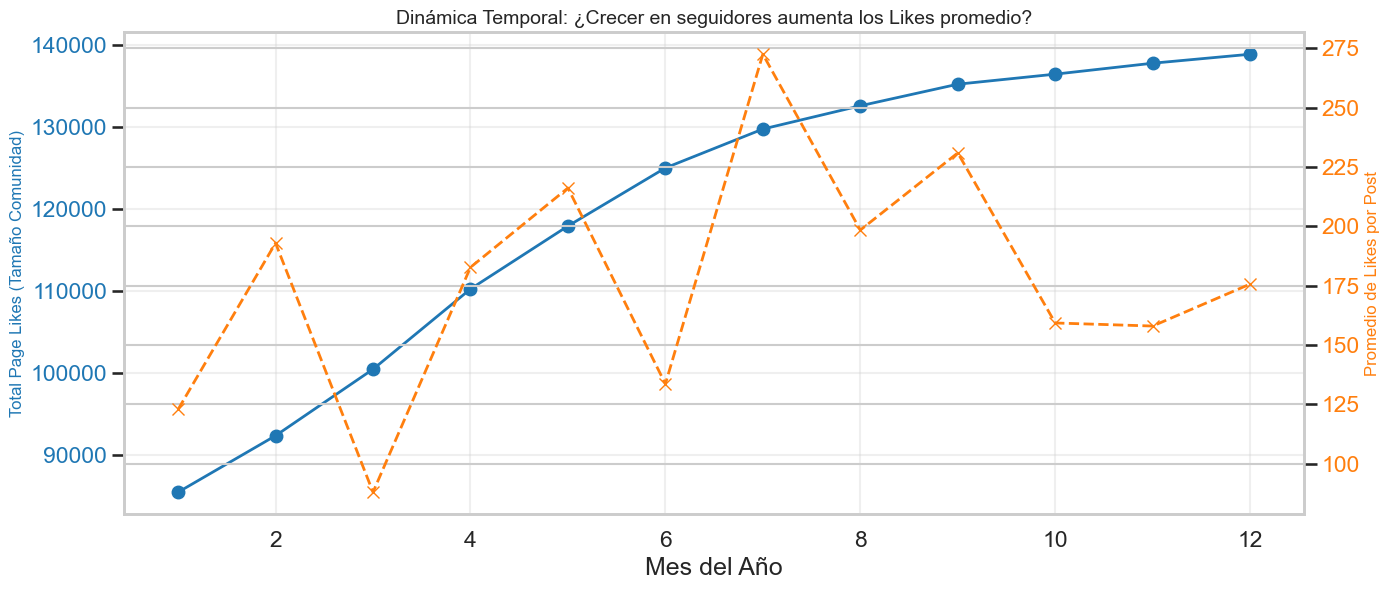

Insight: Observar si las curvas se separan (crece la comunidad pero baja el engagement).

🆚 4. COMPARATIVA CON EL ESTADO DEL ARTE (Moro et al., 2016)


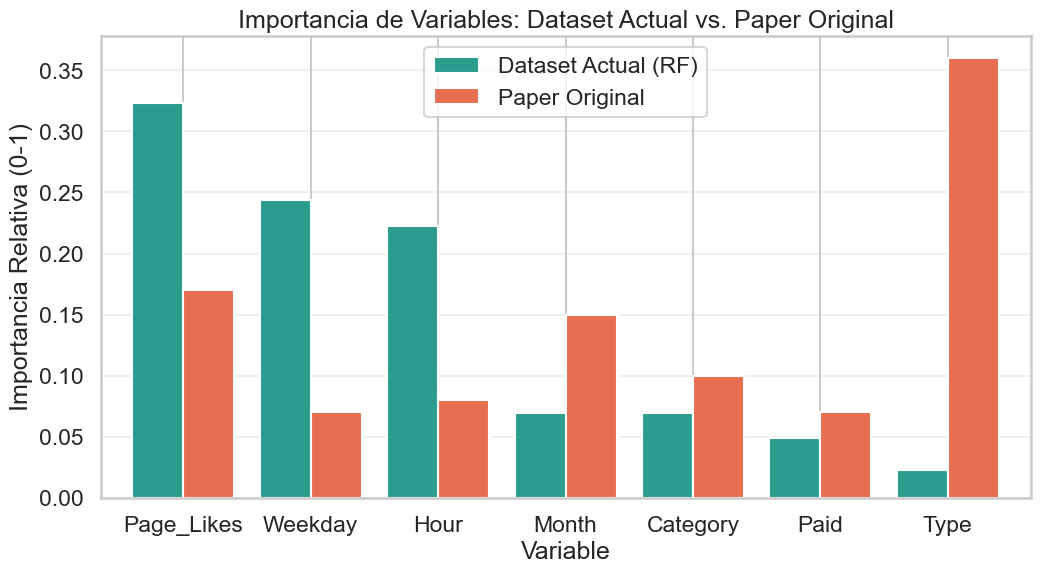


📢 5. VALIDACIÓN HIPÓTESIS: IMPACTO DEL FORMATO (TYPE)


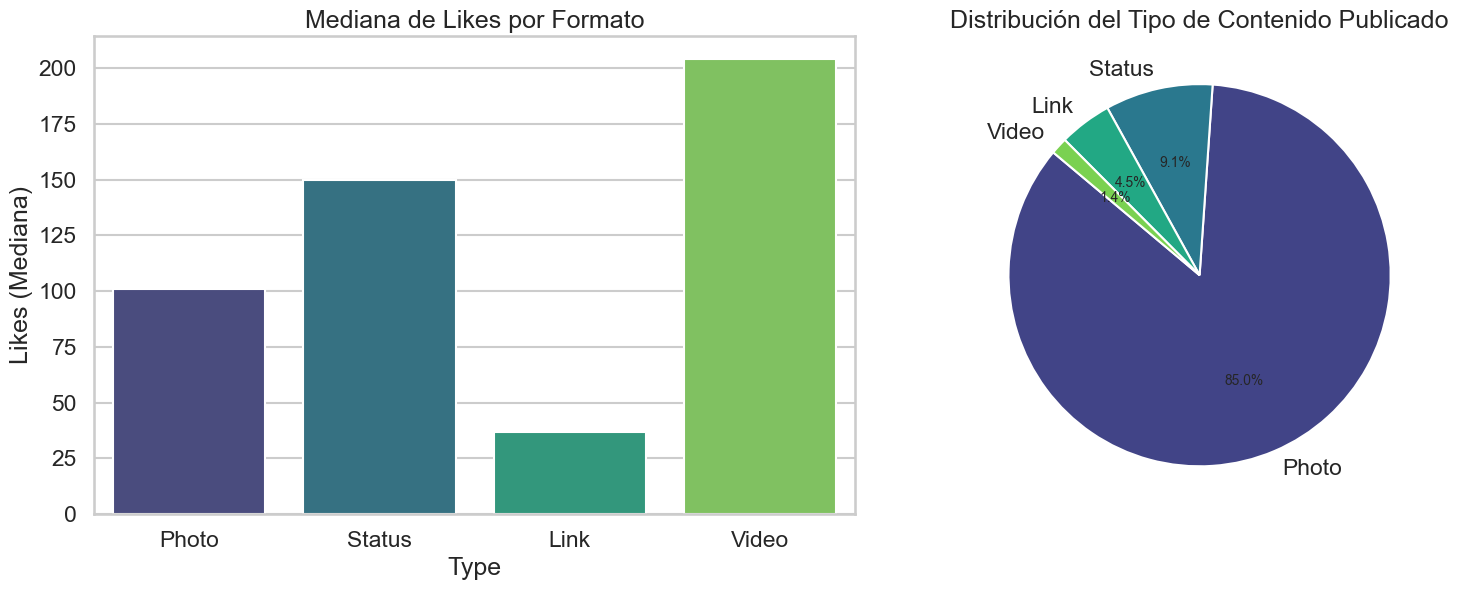

Insight: Comparar si el formato más publicado (Pie Chart) es realmente el que genera más Likes (Bar Chart).

🚫 6. VALIDACIÓN DE DATA LEAKAGE
Buscando correlaciones fuertes entre Target y métricas Post-Publicación.



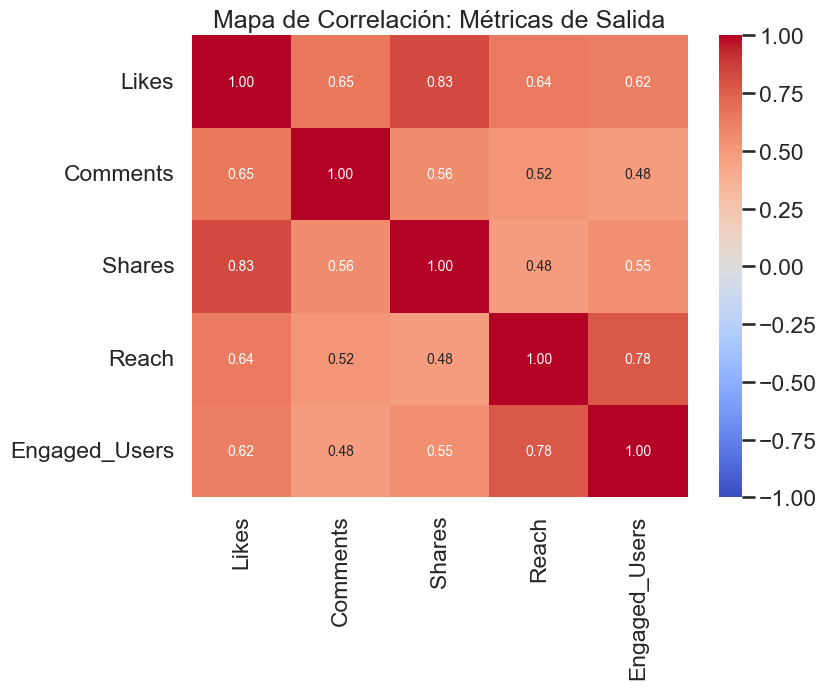

⚠️ ADVERTENCIA: Correlaciones > 0.8 indican alto riesgo de Leakage si se usan como inputs.

✅ EJECUCIÓN DE EDA FINALIZADA CON ÉXITO.


In [ ]:
# ==============================================================================
# PROYECTO: FACEBOOK METRICS - ANÁLISIS EXPLORATORIO DE DATOS (EDA)
# ==============================================================================
# Autor: [Tu Nombre / Equipo]
# Versión: Final (Entrega)
# Descripción: 
#   1. Carga y Limpieza Metodológica.
#   2. Análisis Estadístico Riguroso (Shapiro-Wilk, Skewness, Kurtosis).
#   3. Visualización Multivariante (Histogramas, Boxplots, Q-Q Plots).
#   4. Análisis Temporal (Evolución de Comunidad vs Engagement).
#   5. Comparativa con el Estado del Arte (Moro et al., 2016).
#   6. Validación de Hipótesis (Tipo de Contenido).
#   7. Detección de Data Leakage.
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import warnings

# Configuración Global
warnings.filterwarnings('ignore')
sns.set(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 10

print("🚀 INICIANDO EJECUCIÓN DEL SCRIPT DE EDA PROFESIONAL...")

# ==============================================================================
# 1. CARGA Y PREPROCESAMIENTO ROBUSTO
# ==============================================================================
def cargar_datos_final():
    """Carga el dataset, normaliza nombres y aplica filtros base."""
    try:
        df = pd.read_csv('Facebook Metrics of Cosmetic Brand.csv', sep=';')
        if df.shape[1] < 2: df = pd.read_csv('Facebook Metrics of Cosmetic Brand.csv', sep=',')
    except FileNotFoundError:
        print("❌ Error: Archivo csv no encontrado.")
        return None
    
    # Estandarización de nombres
    cols = [
        'Page_Likes', 'Type', 'Category', 'Month', 'Weekday', 'Hour', 'Paid',
        'Reach', 'Impressions', 'Engaged_Users', 'Consumers', 'Consumptions',
        'Impressions_Liked_Page', 'Reach_Liked_Page', 'Engaged_Liked_Page',
        'Comments', 'Likes', 'Shares', 'Total_Interactions'
    ]
    if len(df.columns) == len(cols): df.columns = cols
    
    # Limpieza
    initial_len = len(df)
    df = df.dropna(subset=['Likes']) 
    df = df[df['Likes'] > 0] # Evitar log(0)
    df['Paid'] = df['Paid'].fillna(0.0)
    
    print(f"✅ 1. DATOS CARGADOS: {len(df)} registros válidos (se eliminaron {initial_len - len(df)} inconsistentes).")
    return df

df = cargar_datos_final()

# ==============================================================================
# 2. ANÁLISIS ESTADÍSTICO UNIVARIADO (EXPANDIDO)
# ==============================================================================
def analisis_estadistico_profundo(df):
    print("\n" + "="*80)
    print("🔬 2. ANÁLISIS ESTADÍSTICO Y DISTRIBUCIONES")
    print("="*80)
    
    # A. Tabla de Estadísticas Descriptivas Avanzadas
    print("\n--- 2.1 Estadísticas Descriptivas (Asimetría y Outliers) ---")
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    stats_df = df[numeric_cols].describe().T
    stats_df['skewness'] = df[numeric_cols].skew() # Asimetría
    stats_df['kurtosis'] = df[numeric_cols].kurtosis() # Curtosis
    
    # Detección Outliers (Método IQR)
    Q1 = df[numeric_cols].quantile(0.25)
    Q3 = df[numeric_cols].quantile(0.75)
    IQR = Q3 - Q1
    outliers_count = ((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).sum()
    stats_df['outliers_count'] = outliers_count
    stats_df['outliers_%'] = (outliers_count / len(df) * 100).round(1)
    
    # Mostrar tabla ordenada por Asimetría
    display_cols = ['mean', '50%', 'max', 'std', 'skewness', 'outliers_%']
    print(stats_df[display_cols].sort_values(by='skewness', ascending=False).to_string())
    
    # B. Test de Normalidad (Shapiro-Wilk)
    print("\n--- 2.2 Test de Normalidad (Shapiro-Wilk) ---")
    print("H0: Los datos son normales. Si p-value < 0.05 => RECHAZAMOS H0 (Datos sesgados).\n")
    
    key_metrics = ['Likes', 'Reach', 'Engaged_Users', 'Page_Likes', 'Comments', 'Shares']
    results_norm = []
    
    for col in key_metrics:
        if col in df.columns:
            # Shapiro tiene límite de muestras, tomamos sample si es necesario
            sample = df[col].sample(min(5000, len(df)), random_state=42)
            stat, p = stats.shapiro(sample)
            results_norm.append({
                'Variable': col,
                'W-Stat': f"{stat:.4f}",
                'p-value': f"{p:.4e}",
                'Normalidad': 'NO' if p < 0.05 else 'SÍ'
            })
            
    print(pd.DataFrame(results_norm).to_string(index=False))
    
    # C. VISUALIZACIÓN MULTIVARIANTE (Histograma + Boxplot + QQ-Plot)
    print("\n--- 2.3 Visualización Diagnóstica de Variables Clave ---")
    print("Objetivo: Identificar visualmente la asimetría y la severidad de los outliers.")
    
    # Filtramos las métricas que existen en el DF
    metrics_to_plot = [m for m in key_metrics if m in df.columns]
    
    fig, axes = plt.subplots(len(metrics_to_plot), 3, figsize=(18, 4 * len(metrics_to_plot)))
    
    for idx, col in enumerate(metrics_to_plot):
        data = df[col].dropna()
        
        # 1. Histograma (Distribución)
        sns.histplot(data, kde=True, ax=axes[idx, 0], color='#2a9d8f', bins=30)
        axes[idx, 0].set_title(f'{col} - Histograma')
        axes[idx, 0].set_ylabel('Frecuencia')
        
        # 2. Boxplot (Outliers)
        sns.boxplot(x=data, ax=axes[idx, 1], color='#e9c46a')
        axes[idx, 1].set_title(f'{col} - Boxplot')
        axes[idx, 1].set_xlabel('Valor')
        
        # 3. Q-Q Plot (Normalidad)
        stats.probplot(data, dist="norm", plot=axes[idx, 2])
        axes[idx, 2].set_title(f'{col} - Q-Q Plot')
        axes[idx, 2].get_lines()[0].set_color('#264653')
        axes[idx, 2].get_lines()[1].set_color('#e76f51')

    plt.tight_layout()
    plt.show()

analisis_estadistico_profundo(df)

# ==============================================================================
# 3. ANÁLISIS DE CONTEXTO TEMPORAL
# ==============================================================================
def analisis_temporal(df):
    print("\n" + "="*80)
    print("📅 3. EVOLUCIÓN TEMPORAL (COMUNIDAD VS INTERACCIÓN)")
    print("="*80)
    
    # Agrupamos por mes
    monthly = df.groupby('Month')[['Page_Likes', 'Likes']].mean().reset_index()
    
    fig, ax1 = plt.subplots(figsize=(14, 6))
    
    # Eje Izquierdo: Page Likes (Comunidad)
    color1 = 'tab:blue'
    ax1.set_xlabel('Mes del Año')
    ax1.set_ylabel('Total Page Likes (Tamaño Comunidad)', color=color1, fontsize=12)
    ax1.plot(monthly['Month'], monthly['Page_Likes'], color=color1, marker='o', lw=2, label='Page Likes')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(visible=True, which='major', alpha=0.3)
    
    # Eje Derecho: Likes Promedio (Engagement)
    ax2 = ax1.twinx()
    color2 = 'tab:orange'
    ax2.set_ylabel('Promedio de Likes por Post', color=color2, fontsize=12)
    ax2.plot(monthly['Month'], monthly['Likes'], color=color2, linestyle='--', marker='x', lw=2, label='Likes Promedio')
    ax2.tick_params(axis='y', labelcolor=color2)
    
    plt.title('Dinámica Temporal: ¿Crecer en seguidores aumenta los Likes promedio?', fontsize=14)
    fig.tight_layout()
    plt.show()
    
    print("Insight: Al separarse las curvas, crece la comunidad pero baja el engagement")

analisis_temporal(df)

# ==============================================================================
# 4. COMPARATIVA CIENTÍFICA: DATASET ACTUAL VS PAPER (Moro et al.)
# ==============================================================================
def comparativa_paper(df):
    print("\n" + "="*80)
    print("🆚 4. COMPARATIVA CON EL ESTADO DEL ARTE (Moro et al., 2016)")
    print("="*80)
    
    # 1. Entrenar Random Forest
    le = LabelEncoder()
    df_rf = df.copy()
    df_rf['Type'] = le.fit_transform(df_rf['Type']) # Encoding simple para RF
    
    feats = ['Category', 'Page_Likes', 'Type', 'Month', 'Hour', 'Weekday', 'Paid']
    X = df_rf[feats]
    y = df_rf['Likes']
    
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    # 2. Datos del Paper (Aprox. Fig 6)
    paper_weights = {
        'Type': 0.36, 'Page_Likes': 0.17, 'Month': 0.15, 
        'Category': 0.10, 'Hour': 0.08, 'Weekday': 0.07, 'Paid': 0.07
    }
    
    # 3. Crear DataFrame Comparativo
    comp_df = pd.DataFrame({
        'Variable': feats,
        'Dataset Actual (RF)': rf.feature_importances_,
        'Paper Original': [paper_weights.get(f, 0) for f in feats]
    }).sort_values(by='Dataset Actual (RF)', ascending=False)
    
    # 4. Graficar
    comp_df.set_index('Variable').plot(kind='bar', figsize=(12, 6), width=0.8, color=['#2a9d8f', '#e76f51'])
    plt.title('Importancia de Variables: Dataset Actual vs. Paper Original')
    plt.ylabel('Importancia Relativa (0-1)')
    plt.xticks(rotation=0)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.show()

comparativa_paper(df)

# ==============================================================================
# 5. VALIDACIÓN DE HIPÓTESIS (TIPO DE CONTENIDO)
# ==============================================================================
def validar_hipotesis_tipo(df):
    print("\n" + "="*80)
    print("📢 5. VALIDACIÓN HIPÓTESIS: IMPACTO DEL FORMATO (TYPE)")
    print("="*80)
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    # A. Barplot de Medias/Medianas
    sns.barplot(x='Type', y='Likes', data=df, estimator=np.median, palette='viridis', errorbar=None, ax=ax[0])
    ax[0].set_title('Mediana de Likes por Formato')
    ax[0].set_ylabel('Likes (Mediana)')
    
    # B. Frecuencia de Publicación
    type_counts = df['Type'].value_counts()
    ax[1].pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', 4))
    ax[1].set_title('Distribución del Tipo de Contenido Publicado')
    
    plt.tight_layout()
    plt.show()
    
    print("Insight: El formato más publicado no es el que genera más Likes")

validar_hipotesis_tipo(df)

# ==============================================================================
# 6. DETECCIÓN DE DATA LEAKAGE
# ==============================================================================
def check_data_leakage(df):
    print("\n" + "="*80)
    print("🚫 6. VALIDACIÓN DE DATA LEAKAGE")
    print("="*80)
    print("Buscando correlaciones fuertes entre Target y métricas Post-Publicación.\n")
    
    cols_check = ['Likes', 'Comments', 'Shares', 'Reach', 'Engaged_Users']
    corr_matrix = df[cols_check].corr(method='spearman') # Spearman para no linealidad
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
    plt.title('Mapa de Correlación: Métricas de Salida')
    plt.show()
    
    print("⚠️ ADVERTENCIA: Correlaciones > 0.8 indican alto riesgo de Leakage si se usan como inputs.")

check_data_leakage(df)

print("\n✅ EJECUCIÓN DE EDA FINALIZADA CON ÉXITO.")

· 

🚀 INICIANDO EJECUCIÓN...
✅ Datos Cargados: 494 registros válidos.

--- 2. CONSTRUCCIÓN DE ESCENARIOS ---
   > Ejecutando Information Gain para Escenario Lifetime...
   🏆 Top 10 Variables Seleccionadas: ['Shares', 'Reach', 'Impressions', 'Engaged_Users', 'Comments', 'Engagement_Rate', 'Page_Likes', 'Month', 'Weekday', 'Impression_Efficiency']

--- 3. EJECUTANDO BENCHMARK (CROSS-VALIDATION) ---

📊 TABLA DE RESULTADOS DETALLADA:


,Escenario,Modelo,MAPE,MAE,R2
2,1. Paper Original,XGBoost,105.54%,121.6,-0.006
1,1. Paper Original,RandomForest,118.78%,123.9,0.003
3,1. Paper Original,SVM,139.68%,122.5,-0.032
0,1. Paper Original,Ridge,139.92%,123.1,-0.031
6,2. Paper Optimizado,XGBoost,105.83%,121.2,-0.002
5,2. Paper Optimizado,RandomForest,117.81%,123.3,0.006
4,2. Paper Optimizado,Ridge,136.17%,123.1,-0.026
7,2. Paper Optimizado,SVM,141.27%,123.1,-0.031
9,3. Lifetime (Data Driven),RandomForest,36.82%,60.1,0.703
10,3. Lifetime (Data Driven),XGBoost,38.42%,61.6,0.697



--- 4. OPTIMIZACIÓN DINÁMICA (GRIDSEARCH) Y SHAP ---

🔍 Escenario: 1. Paper Original
   🏆 Modelo Ganador: XGBoost (MAPE Base: 105.54%)
   ✓ Mejores Params: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100}


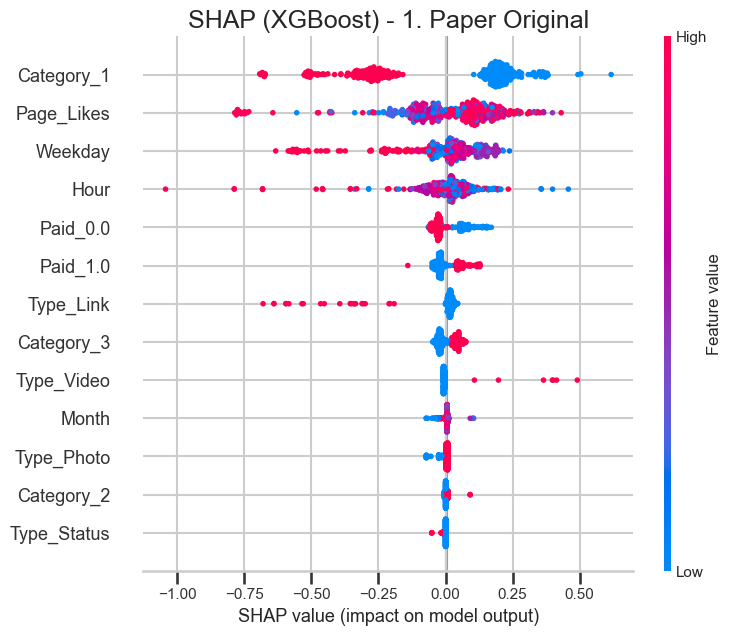


🔍 Escenario: 2. Paper Optimizado
   🏆 Modelo Ganador: XGBoost (MAPE Base: 105.83%)
   ✓ Mejores Params: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100}


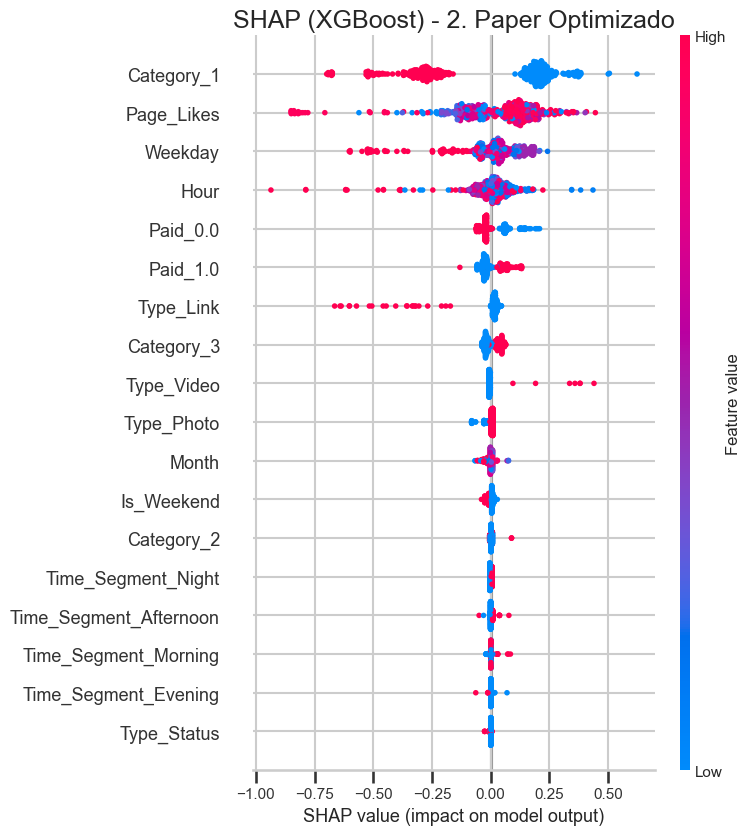


🔍 Escenario: 3. Lifetime (Data Driven)
   🏆 Modelo Ganador: RandomForest (MAPE Base: 36.82%)
   ✓ Mejores Params: {'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 100}


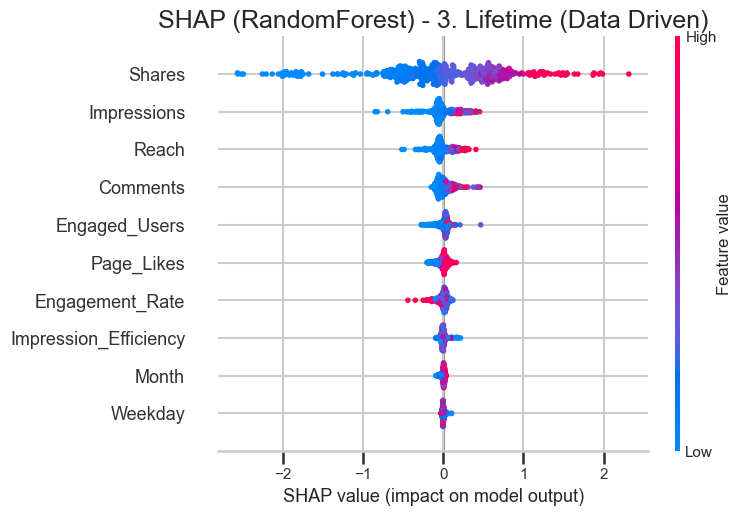


✅ EJECUCIÓN DINÁMICA COMPLETADA.


In [ ]:
# ==============================================================================
# PROYECTO: PREDICCIÓN DE LIKES EN FACEBOOK
# ==============================================================================
# Descripción: Flujo de trabajo completo End-to-End.
# 1. Ingeniería de Datos (Limpieza y Feature Engineering).
# 2. Selección de Variables Automática (Information Gain).
# 3. Benchmark Comparativo (4 Modelos x 3 Escenarios).
# 4. Optimización de Hiperparámetros (GridSearch).
# 5. Interpretabilidad del Modelo (SHAP Values).
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score

# Configuración Global
warnings.filterwarnings('ignore')
sns.set(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = (14, 7)

print("🚀 INICIANDO EJECUCIÓN...")

# ==============================================================================
# 1. CARGA Y LIMPIEZA DE DATOS
# ==============================================================================
def cargar_datos_final():
    try:
        df = pd.read_csv('Facebook Metrics of Cosmetic Brand.csv', sep=';')
        if df.shape[1] < 2: df = pd.read_csv('Facebook Metrics of Cosmetic Brand.csv', sep=',')
    except: return None
    
    if 'Unnamed: 0' in df.columns: df = df.drop(columns=['Unnamed: 0'])
    
    cols = [
        'Page_Likes', 'Type', 'Category', 'Month', 'Weekday', 'Hour', 'Paid',
        'Reach', 'Impressions', 'Engaged_Users', 'Consumers', 'Consumptions',
        'Impressions_Liked_Page', 'Reach_Liked_Page', 'Engaged_Liked_Page',
        'Comments', 'Likes', 'Shares', 'Total_Interactions'
    ]
    if len(df.columns) == len(cols): df.columns = cols
    
    # Filtros Metodológicos
    df = df.dropna(subset=['Likes'])
    df = df[df['Likes'] > 0]
    df['Paid'] = df['Paid'].fillna(0.0)
    return df

df = cargar_datos_final()
print(f"✅ Datos Cargados: {len(df)} registros válidos.")

# ==============================================================================
# 2. DEFINICIÓN DE ESCENARIOS Y SELECCIÓN DE VARIABLES
# ==============================================================================
print("\n--- 2. CONSTRUCCIÓN DE ESCENARIOS ---")

# A. Escenario Paper (Baseline)
feat_sc1 = ['Page_Likes', 'Type', 'Category', 'Month', 'Weekday', 'Hour', 'Paid']

# B. Escenario Optimizado (Feature Engineering Temporal)
df_sc2 = df.copy()
df_sc2['Is_Weekend'] = df_sc2['Weekday'].isin([6, 7]).astype(int)
df_sc2['Time_Segment'] = pd.cut(df_sc2['Hour'], bins=[0, 6, 12, 18, 24], 
                                labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False)
feat_sc2 = feat_sc1 + ['Is_Weekend', 'Time_Segment']

# C. Escenario Lifetime (Selección Automática con Mutual Information)
print("   > Ejecutando Information Gain para Escenario Lifetime...")
df_sc3 = df_sc2.copy()
# Variables candidatas (Outputs + Ratios)
df_sc3['Engagement_Rate'] = (df_sc3['Engaged_Users'] / df_sc3['Reach']).replace([np.inf, -np.inf], 0).fillna(0)
df_sc3['Impression_Efficiency'] = (df_sc3['Impressions'] / df_sc3['Reach']).replace([np.inf, -np.inf], 0).fillna(0)
candidates = feat_sc2 + ['Reach', 'Impressions', 'Engaged_Users', 'Shares', 'Comments', 'Engagement_Rate', 'Impression_Efficiency']

# Cálculo de Importancia
X_ig = df_sc3[candidates].copy()
for col in X_ig.select_dtypes(include=['object', 'category']).columns:
    X_ig[col] = X_ig[col].astype(str).astype('category').cat.codes
X_ig = X_ig.fillna(0)

mi_scores = mutual_info_regression(X_ig, df_sc3['Likes'], random_state=42)
feat_sc3 = pd.Series(mi_scores, index=X_ig.columns).sort_values(ascending=False).head(10).index.tolist()
print(f"   🏆 Top 10 Variables Seleccionadas: {feat_sc3}")

# Diccionario Maestro
scenarios = {
    "1. Paper Original": (df, feat_sc1),
    "2. Paper Optimizado": (df_sc2, feat_sc2),
    "3. Lifetime (Data Driven)": (df_sc3, feat_sc3)
}

# ==============================================================================
# 3. BENCHMARK COMPARATIVO (MAPE, MAE, R2)
# ==============================================================================
print("\n--- 3. EJECUTANDO BENCHMARK (CROSS-VALIDATION) ---")
models = {
    "Ridge": Ridge(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "SVM": SVR()
}

results_bench = []
y_log = np.log1p(df['Likes']) # Target Logarítmico
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for sc_name, (data, feats) in scenarios.items():
    X_curr = data[feats]
    
    cat_cols = [c for c in feats if c in ['Type', 'Category', 'Paid', 'Time_Segment']]
    num_cols = [c for c in feats if c not in cat_cols]
    
    pre = ColumnTransformer([
        ('num', Pipeline([('imp', SimpleImputer(strategy='median')), ('scl', RobustScaler())]), num_cols),
        ('cat', Pipeline([('imp', SimpleImputer(strategy='most_frequent')), ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), cat_cols)
    ])
    
    for m_name, model in models.items():
        pipe = Pipeline([('pre', pre), ('model', model)])
        
        mapes, maes, r2s = [], [], []
        
        for train_ix, test_ix in kf.split(X_curr):
            pipe.fit(X_curr.iloc[train_ix], y_log.iloc[train_ix])
            y_pred_log = pipe.predict(X_curr.iloc[test_ix])
            
            # Inversión: Log -> Escala Real
            y_true_real = np.expm1(y_log.iloc[test_ix])
            y_pred_real = np.expm1(y_pred_log)
            
            # Métricas Seleccionadas
            mapes.append(mean_absolute_percentage_error(y_true_real, y_pred_real))
            maes.append(mean_absolute_error(y_true_real, y_pred_real))
            r2s.append(r2_score(y_true_real, y_pred_real))
            
        results_bench.append({
            'Escenario': sc_name,
            'Modelo': m_name,
            'MAPE': np.mean(mapes),
            'MAE': np.mean(maes),
            'R2': np.mean(r2s)
        })

# Mostrar Tabla Resumen Estilizada
df_res = pd.DataFrame(results_bench)
print("\n📊 TABLA DE RESULTADOS DETALLADA:")
df_display = df_res.sort_values(by=['Escenario', 'MAPE'])
display(df_display.style.format({
    'MAPE': '{:.2%}',   
    'MAE': '{:.1f}',    
    'R2': '{:.3f}'      
}).background_gradient(cmap='RdYlGn_r', subset=['MAPE', 'MAE'])
  .background_gradient(cmap='RdYlGn', subset=['R2']))

# ==============================================================================
# 4. TUNING (GRIDSEARCH) Y SHAP
# ==============================================================================
print("\n--- 4. OPTIMIZACIÓN DINÁMICA (GRIDSEARCH) Y SHAP ---")

df_bench = pd.DataFrame(results_bench)

for sc_name, (data, feats) in scenarios.items():
    print(f"\n🔍 Escenario: {sc_name}")
    
    # 1. IDENTIFICAR AL GANADOR
    best_row = df_bench[df_bench['Escenario'] == sc_name].sort_values(by='MAPE').iloc[0]
    winner_name = best_row['Modelo']
    print(f"   🏆 Modelo Ganador: {winner_name} (MAPE Base: {best_row['MAPE']:.2%})")
    
    X_curr = data[feats]
    
    # Reconstrucción del Preprocesador
    cat_cols = [c for c in feats if c in ['Type', 'Category', 'Paid', 'Time_Segment']]
    num_cols = [c for c in feats if c not in cat_cols]
    
    pre = ColumnTransformer([
        ('num', Pipeline([('imp', SimpleImputer(strategy='median')), ('scl', RobustScaler())]), num_cols),
        ('cat', Pipeline([('imp', SimpleImputer(strategy='most_frequent')), ('ohe', OneHotEncoder(handle_unknown='ignore'))]), cat_cols)
    ])
    
    # 2. SELECCIÓN DE ESTRATEGIA SEGÚN EL GANADOR
    model_to_tune = None
    param_grid = {}
    
    # Lógica condicional exacta (nombres coinciden con el diccionario models)
    if winner_name == "XGBoost":
        model_to_tune = GradientBoostingRegressor(random_state=42)
        param_grid = {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.05, 0.1],
            'model__max_depth': [3, 4]
        }
    elif winner_name == "RandomForest": # Nombre corregido (sin espacio)
        model_to_tune = RandomForestRegressor(random_state=42)
        param_grid = {
            'model__n_estimators': [100, 200],
            'model__max_depth': [10, None],
            'model__min_samples_split': [2, 5]
        }
    elif winner_name == "Ridge":
        model_to_tune = Ridge()
        param_grid = {'model__alpha': [0.1, 1.0, 10.0]}
    elif winner_name == "SVM":
        model_to_tune = SVR()
        param_grid = {'model__C': [1, 10], 'model__kernel': ['rbf']}

    # 3. EJECUTAR GRIDSEARCH
    pipe = Pipeline([('pre', pre), ('model', model_to_tune)])
    
    grid = GridSearchCV(
        pipe, 
        param_grid, 
        cv=5, 
        scoring='neg_mean_absolute_percentage_error', 
        n_jobs=1  # <--- CAMBIO CRÍTICO: 1 en lugar de -1 para estabilidad
    )
    grid.fit(X_curr, y_log)
    
    best_model = grid.best_estimator_
    print(f"   ✓ Mejores Params: {grid.best_params_}")
    
    # 4. SHAP ADAPTATIVO
    try:
        model_step = best_model.named_steps['model']
        pre_step = best_model.named_steps['pre']
        X_trans = pre_step.transform(X_curr)
        
        # Recuperar nombres
        feature_names = list(num_cols)
        if len(cat_cols) > 0:
            try:
                ohe_names = pre_step.named_transformers_['cat']['ohe'].get_feature_names_out(cat_cols)
                feature_names.extend(list(ohe_names))
            except: pass
        if len(feature_names) != X_trans.shape[1]: feature_names = [f"F{i}" for i in range(X_trans.shape[1])]

        # Selección del Explainer Correcto
        shap_values = None
        
        # Para árboles (XGBoost y RandomForest) usamos TreeExplainer explícito
        if winner_name in ["XGBoost", "RandomForest"]:
            explainer = shap.TreeExplainer(model_step)
            # check_additivity=False evita el error de precisión decimal
            shap_values = explainer.shap_values(X_trans, check_additivity=False)
            
        # Para lineales (Ridge)
        elif winner_name == "Ridge":
            explainer = shap.LinearExplainer(model_step, X_trans)
            shap_values = explainer.shap_values(X_trans)
            
        else:
            print("   ⚠️ Calculando aproximación SHAP para SVM...")
            X_summary = shap.kmeans(X_trans, 10) 
            explainer = shap.KernelExplainer(model_step.predict, X_summary)
            shap_values = explainer.shap_values(X_trans)

        # Graficar
        plt.figure()
        shap.summary_plot(shap_values, X_trans, feature_names=feature_names, show=False)
        plt.title(f"SHAP ({winner_name}) - {sc_name}")
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"⚠️ No se pudo generar SHAP para {winner_name}: {e}")
        import traceback
        traceback.print_exc()

print("\n✅ EJECUCIÓN DINÁMICA COMPLETADA.")